# Hashing and mutation

At the core of `provenance` is the ability to hash arbritary python data structures. `Artifact` ids are hashes of a function's metadata and the arguments for a given invocaiton. The `value_id` of an `Artifact` is the hash of the actual `value` object (the return value from the decorated function).

The hashing approach (and implementaiton) was created in `joblib` and it leverages `pickle` to walk any python data structures and produces a message digest of the resulting pickle bytecode. Therefore, any argument or return value to a `provenance` function must be picklable.

## Hashing Semantics: Reference vs Value

`provenance` adopts value-based hashing semantics, which is in contrast to `joblib`'s referenced-based semantics. The best way to illustrate the difference is with some examples.

In [1]:
a = [1, 2, 3]
nested_references = [a, a]
nested_values =  [[1, 2, 3], [1, 2, 3]]

Would you expect `hash(nested_references) == hash(nested_values)`? Lets take a look at the hashes with both appraoches.

In [2]:
import joblib as jl
import provenance as p

In [3]:
%load_ext yamlmagic

In [4]:
%%yaml basic_config
blobstores:
    disk:
        type: disk
        cachedir: /tmp/provenance-intro-artifacts
        read: True
        write: True
        delete: True
artifact_repos:
    local:
        type: postgres
        db: postgresql://localhost/provenance-intro
        store: 'disk'
        read: True
        write: True
        delete: True
        # this option will create the database if it doesn't exist
        create_db: True
default_repo: local

<IPython.core.display.Javascript object>

In [5]:
# skip this in the docs...
#import provenance.repos as pr
#p.set_default_repo(pr.MemoryRepo())

# Load a more realisitc config in case people want to play around with it in Binder
p.load_config(basic_config)

INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running stamp_revision  -> e0317ab07ba4


In [6]:
print('Joblib Hashing')
print('nested_references ',jl.hash(nested_references))
print('nested_values     ', jl.hash(nested_values))

Joblib Hashing
nested_references  a9a5b8ad17431309cf00b14a45cedd7e
nested_values      70dc9c81d27cc89b76d98bcd52de04d0


In [7]:
print('Provenance Hashing')
print('nested_references ', p.hash(nested_references))
print('nested_values     ', p.hash(nested_values))

Provenance Hashing
nested_references  ea971dde80510d0bd01ed7c9e246df52087ba7f4
nested_values      ea971dde80510d0bd01ed7c9e246df52087ba7f4


In the reference-based approach, as implemented by `joblib`, the references of nested objects are taken into account. With the value-based approach taken by `provenance` only the values of the datas strucrues involved are used to compute the hash. 

## Mutation and function behavior

While hahsing semantics may seem like an unimportant implementation detail choosing one or the other can result in stark differences in behavior. Consider the following:

In [8]:
def mutating_nested(arrays):
    arrays[0][0] += 1
    return sum(map(sum, arrays))


a = [1, 2, 3]
nested_references = [a, a]
nested_values =  [[1, 2, 3], [1, 2, 3]]

{'with_references': mutating_nested(nested_references),
 'nested_values': mutating_nested(nested_values)}


{'nested_values': 13, 'with_references': 14}

The output of the function is not only dependent on the values but also on the references! If value-based hashing were to be used when memoizing this function you would result in incorrect cache hits. This is why `joblib` takes the conservative approach of hashing based on references. That way you can memoize the above function just fine and don't have to worry about false cache hits.

However, there are downsides in using reference-based hashing. In particular, you end up with more false cache misses resulting in needless recomputation. This was the original motivation for switching to use value-based semantics. Outside of that having functions that mutate state when caching is involved can lead to subtle bugs downstream (since a cache hit will prevent mutation of the inputs and potential downstream behavior). To avoid these types of issues and to allow for value-based hashing `provenance` only allows functions that do not mutate their inputs. In practice the majoirty of `provenance`ed functions end up being [pure functions](https://en.wikipedia.org/wiki/Pure_function) while a few functions that kick off the pipeline deterministicly fetch data from a data store.

When a `provenance`ed function mutates its input an error is thrown so the user can fix the mutation (typically by doing a `copy` or `deepcopy`):

In [9]:
@p.provenance()
def mutating_nested(arrays):
    arrays[0][0] += 1
    return sum(map(sum, arrays))


a = [1, 2, 3]
nested_references = [a, a]

mutating_nested(nested_references)

ImpureFunctionError: The __main__.mutating_nested function modified arguments: (arrays)

In this case you would avoid mutation like so:

In [10]:
from copy import deepcopy

@p.provenance()
def nonmutating_nested(arrays):
    arrays = deepcopy(arrays)
    arrays[0][0] += 1
    return sum(map(sum, arrays))


a = [1, 2, 3]
nested_references = [a, a]

nonmutating_nested(nested_references)


<provenance.ArtifactProxy(79e7a2510b6c796f510260816973f73178785384) 14 >

This will cause you to write your pipelines a bit different. For example, instead of creating a `scikit-learn` model in function and then fitting it another you would have a single function that creates the model and fits it all at once. Or you would decorate a function higher up in the stack and write mutating functions that get called from it. What is important is that inputs to functions are not mutated.

## Warning about `copy` mutating the original object

In _rare_ cases the act of `copy`ing of an object may mutate the orginal object, at least from the perspective of `pickle`. What is usually happenig is that underlying libraries are doing some sort of operation lazily prior to the `copy` which causes the `pickle` bytecode to be different. The only way to workaround this is to do a copy of the object before it is passed into a funciton with `provenance`.


## Mutation of `ArtifactProxy`s

Once a cached result, i.e. an `ArtifactProxy`, is returned from a decorated function you should not mutate it before sending it into another decoarated function. By doing so you would be misrepresenting the value of the input, corrupting the provenance of the resulting artifact. Here is an example of what NOT to do and why it is a bad idea to mutate `ArtifactProxy`s:

In [11]:
@p.provenance()
def repeat(element, how_many):
    return [element] * how_many

@p.provenance()
def tracked_sum(array):
    return sum(array)

numbers = repeat(1, 3)
numbers[0] += 10
result_after_mutation = tracked_sum(numbers)
result_after_mutation

<provenance.ArtifactProxy(41ab5b4b904648618493b48c3f764f7abb0eab3a) 13 >

The `result_after_mutation` is correct but the lineage does not capture the mutation making the provenance incorrect:

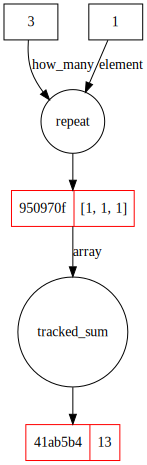

In [16]:
import provenance.vis as vis
reloaded_result = p.load_proxy(result_after_mutation.artifact.id)

vis.visualize_lineage(reloaded_result)

If you don't trust yourself (or your team) to not mutate `ArtifactProxy`s then you can configure `provenance` to check that a proxy was not mutated prior to having it passed in. With this setting a `MutatedArtifactValueError` will be raised when the mutated artifact is passed to another decoarted function.

In [14]:
p.set_check_mutations(True)

numbers = repeat(1, 3)
numbers[0] += 10
tracked_sum(numbers)


MutatedArtifactValueError: Artifact 950970fbb2fd415674f14947091a8e7258082198, of type <class 'list'> was mutated before being passed to __main__.tracked_sum as arguments (array)

## Keep calm!

All this talk of avoiding mutation may seem daunting and different from how you are used to writing functions in Python. It can take some time getting used to it but in the end most tasks in pipelines fit into the mold of a pure function and so it really isn't as bad as you might be thinking!

![Keep calm and pipeline on](images/keep_calm_pipeline_on.png)